# Simple regression model selection


In [1]:
from typing import NamedTuple
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from pcv.inference import run_cv_sel
from pcv.welford import *
import arviz as az
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## Model definition

Gaussian linear regression

In [2]:
class Theta(NamedTuple):
    beta: jax.Array
    sigsq: jax.Array

In [3]:
y_key, X_key = jax.random.split(jax.random.PRNGKey(0))
N = 100
beta0 = jnp.array([1.0, 1.0, 1.0, 0.3])
p = len(beta0)
sigsq0 = jnp.array(2.0)
X = tfd.Normal(loc=0, scale=1).sample(sample_shape=(N, p), seed=X_key)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


To break inference, simply inject an outlier into the data. Remember jax arrays are immutable so we need this stange syntax.

In [4]:
y = X@beta0 + tfd.Normal(loc=0, scale=jnp.sqrt(sigsq0)).sample(sample_shape=(N,), seed=y_key)

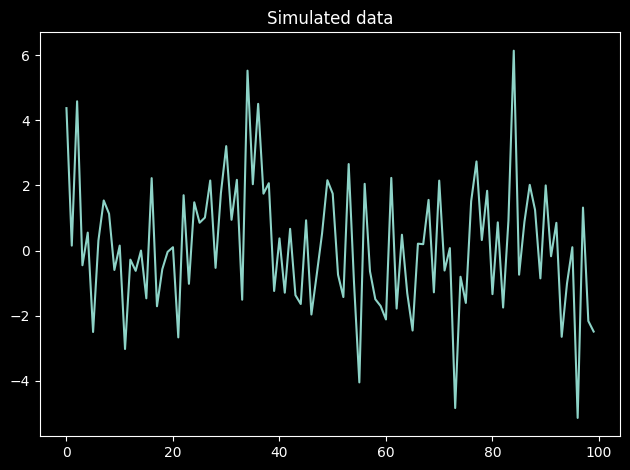

In [5]:
plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [6]:
# use exp to transform sigsq to unconstrained space
sigsq_t = tfb.Exp()

beta_prior = tfd.MultivariateNormalDiag(loc=jnp.zeros(p), scale_diag=jnp.ones(p))
sigsq_prior = tfd.Gamma(concentration=1.0, rate=1.0)


def logjoint_density(theta: Theta, fold_id: int, model_id: int) -> jax.Array:
    """Log joint density for a given fold.
    
    Args:
      theta: model parameters
      fold_id: zero-based fold id for training set
      model_id: 0 for model A, 1 for model B
    """
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    sigsq_ldj = sigsq_t.forward_log_det_jacobian(theta.sigsq)
    # prior is same for all folds
    lp = beta_prior.log_prob(theta.beta) + sigsq_prior.log_prob(sigsq)
    # likelihood for fold
    ll_mask = ((jnp.arange(N) % 5) != fold_id).astype(jnp.float32)
    # model A has all the predictors, model B is missing the last predictor
    beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
    ll_contribs = tfd.Normal(loc=X @ (theta.beta * beta_mask), scale=jnp.sqrt(sigsq)).log_prob(y)
    ll = (ll_mask * ll_contribs).sum()
    return lp + ll + sigsq_ldj


# predictive density log p(y_train|theta)
def log_pred(theta, fold_id, model_id):
    # transform to constrained space
    sigsq = sigsq_t.forward(theta.sigsq)
    pred_mask = (jnp.arange(N) % 5) == fold_id
    beta_mask = jnp.where(model_id == 0, jnp.ones(p), jnp.concatenate([jnp.ones(p-1), jnp.zeros(1)]))
    ll_contribs = tfd.Normal(loc=X @ (theta.beta * beta_mask), scale=jnp.sqrt(sigsq)).log_prob(y)
    return (pred_mask * ll_contribs).sum()


# random initialization in the constrained parameter space
def make_initial_pos(key):
    k1, k2 = jax.random.split(key)
    theta = Theta(
      beta=jax.random.normal(key=k1, shape=(p,)),
      sigsq=jax.random.normal(key=k2))
    return theta

## Inference

Ok let's actually run some MCMC

In [7]:
inference_key = jax.random.PRNGKey(42)

In [8]:
results = run_cv_sel(
       prng_key=inference_key,
       logjoint_density=logjoint_density,
       log_p=log_pred,
       make_initial_pos=make_initial_pos,
       num_folds=5,
       num_chains=4,
       batch_size=100,
       warmup_iter=1000,
       max_batches=10
)

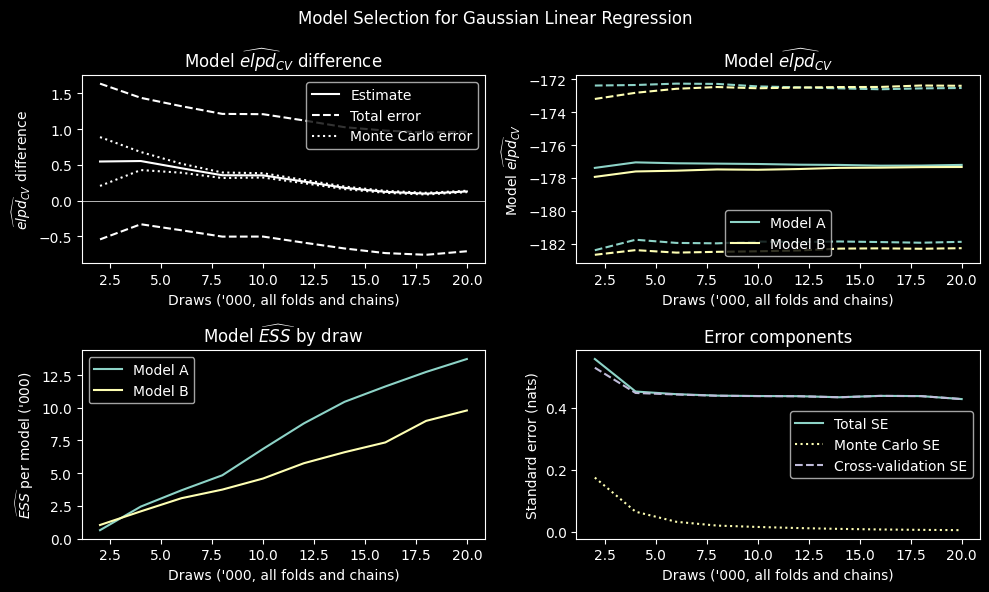

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
((p_diff, p_elpds), (p_ess, p_err)) = axes
draws, ess = results['fold_draws'] * 5e-3, results['model_ess'] * 5e-3
diff_elpd, diff_se = results['diff_elpd'], results['diff_se']
diff_mcse, diff_cvse = results['diff_mcse'], results['diff_cvse']

line_m = p_diff.plot(draws, diff_elpd, linestyle='solid', color='w')
line_se = p_diff.plot(draws, diff_elpd + 1.96 * diff_se, linestyle='dashed', color='w')
p_diff.plot(draws, diff_elpd - 1.96 * diff_se, linestyle='dashed', color='w')
line_mcse = p_diff.plot(draws, diff_elpd + 1.96 * diff_mcse, linestyle='dotted', color='w')
p_diff.plot(draws, diff_elpd - 1.96 * diff_mcse, linestyle='dotted', color='w')
p_diff.axhline(y=0, color='w', linestyle='solid', linewidth=0.5)
p_diff.set_title(r'Model $\widehat{elpd}_{CV}$ difference')
p_diff.set_xlabel('Num. draws (all folds, chains)')
p_diff.set_ylabel(r'$\widehat{elpd}_{CV}$ difference')
p_diff.legend([line_m[0], line_se[0], line_mcse[0]], ['Estimate', 'Total error', 'Monte Carlo error'])

model_elpd, model_se = results['model_elpd'], results['model_se']
plot_handles = []
for m in [0, 1]:
    plot = p_elpds.plot(draws, model_elpd[:, m], linestyle='solid')
    p_elpds.plot(draws, model_elpd[:, m] + 1.96 * model_se[:, m], linestyle='dashed', color=plot[0].get_color())
    p_elpds.plot(draws, model_elpd[:, m] - 1.96 * model_se[:, m], linestyle='dashed', color=plot[0].get_color())
    plot_handles.append(plot[0])
p_elpds.set_title(r'Model $\widehat{elpd}_{CV}$')
p_elpds.legend(handles=plot_handles, labels=['Model A', 'Model B'])
p_elpds.set_ylabel(r'Model $\widehat{elpd}_{CV}$')

p_ess.plot(draws, ess, linestyle='solid')
p_ess.set_title(r'Model $\widehat{ESS}$ by draw')
p_ess.legend(['Model A', 'Model B'])
p_ess.set_ylabel(r"$\widehat{ESS}$ per model ('000)")

p_err.plot(draws, diff_se, label='Total SE', linestyle='solid')
p_err.plot(draws, diff_mcse, label='Monte Carlo SE', linestyle='dotted')
p_err.plot(draws, diff_cvse, label='Cross-validation SE', linestyle='dashed')
p_err.legend()
p_err.set_title('Error components')
p_err.set_ylabel('Standard error (nats)')

for rax in axes:
    for ax in rax:
        ax.set_xlabel("Draws ('000, all folds and chains)")

fig.suptitle("Model Selection for Gaussian Linear Regression")
fig.tight_layout()

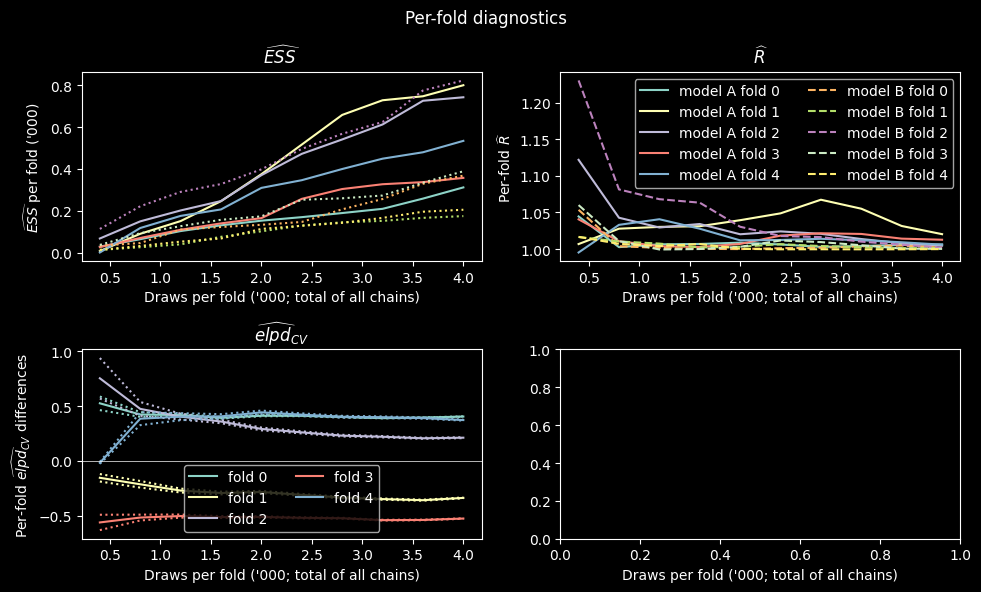

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
((p_ess, p_rhat), (p_elpds, _)) = axes
drawsk, essk = results['fold_draws'] * 1e-3, results['fold_ess'] * 1e-3
K = results['num_folds']

p_ess.plot(drawsk, essk[:,:5], linestyle='solid')
p_ess.plot(drawsk, essk[:,5:], linestyle='dotted')
p_ess.set_title(r'$\widehat{ESS}$')
p_ess.set_ylabel(r"$\widehat{ESS}$ per fold ('000)")

p_rhat.plot(drawsk, results['fold_rhat'][:,:K], linestyle='solid')
p_rhat.plot(drawsk, results['fold_rhat'][:,K:], linestyle='dashed')
p_rhat.set_title(r'$\widehat{R}$')
p_rhat.set_ylabel(r'Per-fold $\widehat{R}$')
p_rhat.legend([f'model {"A" if i <= 4 else "B"} fold {i % 5}' for i in range(10)], ncol=2)

fold_diff, fold_mcse = results['fold_elpd_diff'], results['fold_mcse']
handles = []
for k in range(K):
    line = p_elpds.plot(drawsk, fold_diff[:,k], linestyle='solid', label=f'fold {k}')
    p_elpds.plot(drawsk, fold_diff[:,k] + 1.96 * fold_mcse[:,k], linestyle='dotted', color=line[0].get_color())
    p_elpds.plot(drawsk, fold_diff[:,k] - 1.96 * fold_mcse[:,k], linestyle='dotted', color=line[0].get_color())
    handles.append(line[0])
p_elpds.axhline(y=0, color='w', linestyle='solid', linewidth=0.5)
p_elpds.set_title(r'$\widehat{elpd}_{CV}$')
p_elpds.set_ylabel(r'Per-fold $\widehat{elpd}_{CV}$ differences')
p_elpds.legend(handles=handles, ncol=2)

for rax in axes:
    for ax in rax:
        ax.set_xlabel("Draws per fold ('000; total of all chains)")

fig.suptitle('Per-fold diagnostics')

plt.tight_layout()
plt.show()